In [1]:
#include <iostream>
#include <sstream>
#include "TFile.h"
#include "TH1F.h"
#include "TCanvas.h"
#include "TMath.h"
#include "TKey.h"
#include <algorithm>    // std::max

int rebinFactor = 1;

TCanvas* canvasMass = new TCanvas("Masses","Masses",20, 20, 900,900);
TCanvas* canvasHeliAngles = new TCanvas("Angles helicity stystem","Angles helicity stystem",50, 70, 900,900);
TCanvas* canvasGJAngles = new TCanvas("Angles Gottfried Jackson stystem","Angles Gottfried Jackson stystem",
                                        80, 120,900,900);

In [2]:
void DataFitRebin(int factor) {
    rebinFactor=factor;
    return;
}

In [3]:
void DataFitComp2(TH1F* histoData, TH1F* histoFit) {
    histoData->SetLineColor(kRed);
    histoFit->SetLineColor(kBlack);

    histoData->SetLineWidth(2);
    histoFit->SetLineWidth(2);

    histoFit->SetFillColor(kYellow-10);
    
    histoFit->SetMinimum(0);
    histoFit->SetMaximum(histoFit->GetMaximum()*1.3);
    
    histoFit->Draw("hist");
    histoFit->Draw("same");
    histoData->Draw("same");
    
    return;
}

In [4]:
double CalcHistoChi2(TH1F* histoData, TH1F* histoFit) {

   int nbins1 = histoData->GetNbinsX();
   int nbins2 = histoFit->GetNbinsX();

   if(nbins1 != nbins2){
      std::cout << "ERROR: nbins1!=nbins2" << std::endl;
   }

   double chi2=0;
   int nonzerobins=0;
   for(int i=1;i<=nbins1;i++) {
      if(histoData->GetBinContent(i) == 0 || histoFit->GetBinContent(i) == 0)
         continue;
      // if(histoData->GetBinContent(i) == 0 && histoFit->GetBinContent(i) == 0)
      //         continue;


      //     double error = sqrt(histoData->GetBinContent(i) + histoFit->GetBinContent(i));
      double error =  sqrt(histoData->GetBinError(i)*histoData->GetBinError(i) 
                           + histoFit->GetBinError(i)*histoFit->GetBinError(i));
       
      chi2+=pow(histoData->GetBinContent(i) - histoFit->GetBinContent(i), 2)/(error*error);
      // std::cout << pow(histoData->GetBinContent(i) - histoFit->GetBinContent(i), 2)/(error*error) << std::endl;
      nonzerobins++;
   }
   double chi2Root=histoData->Chi2Test(histoFit,"WW");
   std::cout << "Chi2 for histo " << histoData->GetName() << "\t" << chi2/nonzerobins 
             << "\tp =" << TMath::Prob(chi2, nonzerobins) 
             << "\tpRoot=" << chi2Root  << std::endl;

   return chi2;
}


In [5]:
double CalcKolmogorov(TH1F* histoData, TH1F* histoFit) {
  double ksTestResult = histoData->KolmogorovTest(histoFit);
  std::cout << "Kolmogorov-Smirnov test for histo " << histoData->GetName() 
            << "\tp = " << ksTestResult << std::endl;
  return ksTestResult;  
}

In [6]:
void DataFitCompare(std::string rootFileName, std::string histname, bool createcanvas) {
    TFile* tFile= new TFile(rootFileName.c_str());
    std::string dataName = "Data" + histname;
    std::string fitName = "Fit" + histname;

    TH1F* histoData = (TH1F*)tFile->Get(dataName.c_str());
    TH1F* histoFit = (TH1F*)tFile->Get(fitName.c_str());
    histoData->Rebin(rebinFactor);
    histoFit->Rebin(rebinFactor);
    if(createcanvas)
    //     TCanvas* canvas = new TCanvas("canvas","c1",1000,1000);

    std::cout << "\n" << std::endl;
    CalcHistoChi2(histoData, histoFit);
    CalcKolmogorov(histoData, histoFit);
    std::cout << "\n" << std::endl;
    DataFitComp2(histoData, histoFit);
    return;
}


In [7]:
void DataFitCompareAll(std::string rootFileName, bool saveImage) {
  TFile* tFile= new TFile(rootFileName.c_str());   
   std::vector<std::string> histnamesMasses;
   std::vector<std::string> histnamesAnglesHeli;
   std::vector<std::string> histnamesAnglesGJ;

   std::string strTheta("Theta");
   std::string strPhi("Phi");
   std::string strGJ("GJ");

   TIter nextkey(tFile->GetListOfKeys());
   TKey *key;

   while ((key = (TKey*)nextkey())) {
      
      TH1F *histo = (TH1F*)key->ReadObj();
      const char* name = histo->GetName();
      //      std::cout << name << std::endl;
      std::string sname(name);
      std::string pname = sname.substr(0, 4);
      std::string aname = sname.substr(4);
      
      if(pname == "Data"){
        //sort angle hists
        if ( (aname.find("Theta") != string::npos) || (aname.find("Phi") != string::npos) ){
          //angle hists in GJ system
          if ( aname.find("GJ") != string::npos) histnamesAnglesGJ.push_back(aname);
          else histnamesAnglesHeli.push_back(aname);
                    }
        else histnamesMasses.push_back(aname);
      }
   }

   int numhistsMasses = histnamesMasses.size();
   canvasMass->Divide(std::ceil(sqrt(numhistsMasses)), std::ceil(sqrt(numhistsMasses)));
   for(int i=0; i<numhistsMasses; i++){
      canvasMass->cd(i+1);
      DataFitCompare(rootFileName, histnamesMasses.at(i), false);
   }

   int numhistsHeliAngles = histnamesAnglesHeli.size();
   canvasHeliAngles->Divide(std::ceil(sqrt(numhistsHeliAngles)), std::ceil(sqrt(numhistsHeliAngles)));
   for(int i=0; i<numhistsHeliAngles; i++){
      canvasHeliAngles->cd(i+1);
      DataFitCompare(rootFileName, histnamesAnglesHeli.at(i), false);
   }
   
   int numhistsGJAngles = histnamesAnglesGJ.size();
   canvasGJAngles->Divide(std::ceil(sqrt(numhistsGJAngles)), std::ceil(sqrt(numhistsGJAngles)));
   for(int i=0; i<numhistsGJAngles; i++){
      canvasGJAngles->cd(i+1);
      DataFitCompare(rootFileName, histnamesAnglesGJ.at(i), false);
   }

   if(saveImage){
      canvasMass->SaveAs("DataFitCompFileMasses.png");
      canvasHeliAngles->SaveAs("DataFitCompFileHeliAngles.png");
      canvasGJAngles->SaveAs("DataFitCompFileGJAngles.png");
   }
}   



Chi2 for histo Datapion0Apion0B	0.965238	p =0.578647	pRoot=0.550302
Kolmogorov-Smirnov test for histo Datapion0Apion0B	p = 0.999998


Chi2 for histo Datapion0Aeta	1.02195	p =0.421113	pRoot=0.203972
Kolmogorov-Smirnov test for histo Datapion0Aeta	p = 0.727107


Chi2 for histo Datapion0Beta	1.24239	p =0.0531359	pRoot=0.0461877
Kolmogorov-Smirnov test for histo Datapion0Beta	p = 0.982953


Chi2 for histo DataThetaHeli_pion0Apion0B_Frompion0Apion0Beta	0.897458	p =0.759248	pRoot=0.737875
Kolmogorov-Smirnov test for histo DataThetaHeli_pion0Apion0B_Frompion0Apion0Beta	p = 0.949935


Chi2 for histo DataPhiHeli_pion0Apion0B_Frompion0Apion0Beta	1.23261	p =0.0572281	pRoot=0.0503353
Kolmogorov-Smirnov test for histo DataPhiHeli_pion0Apion0B_Frompion0Apion0Beta	p = 0.904724


Chi2 for histo DataThetaHeli_pion0Aeta_Frompion0Apion0Beta	1.17114	p =0.116277	pRoot=0.104303
Kolmogorov-Smirnov test for histo DataThetaHeli_pion0Aeta_Frompion0Apion0Beta	p = 0.110322


Chi2 for histo DataPhiHeli_pion0Aeta_F

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



Chi2 for histo DataThetaGJ_pion0B_Frompion0Apion0B	0.997031	p =0.489565	pRoot=0.461791
Kolmogorov-Smirnov test for histo DataThetaGJ_pion0B_Frompion0Apion0B	p = 0.79276


Chi2 for histo DataPhiGJ_pion0B_Frompion0Apion0B	0.935408	p =0.662587	pRoot=0.636043
Kolmogorov-Smirnov test for histo DataPhiGJ_pion0B_Frompion0Apion0B	p = 0.366517


Chi2 for histo DataThetaGJ_pion0A_Frompion0Aeta	0.77408	p =0.954347	pRoot=0.946903
Kolmogorov-Smirnov test for histo DataThetaGJ_pion0A_Frompion0Aeta	p = 0.999126


Chi2 for histo DataPhiGJ_pion0A_Frompion0Aeta	1.02418	p =0.414223	pRoot=0.386848
Kolmogorov-Smirnov test for histo DataPhiGJ_pion0A_Frompion0Aeta	p = 0.208214


Chi2 for histo DataThetaGJ_pion0B_Frompion0Beta	0.898192	p =0.757509	pRoot=0.734099
Kolmogorov-Smirnov test for histo DataThetaGJ_pion0B_Frompion0Beta	p = 0.991458


Chi2 for histo DataPhiGJ_pion0B_Frompion0Beta	0.936502	p =0.65963	pRoot=0.633013
Kolmogorov-Smirnov test for histo DataPhiGJ_pion0B_Frompion0Beta	p = 0.281276




Info in <TCanvas::Print>: png file DataFitCompFileMasses.png has been created
Info in <TCanvas::Print>: png file DataFitCompFileHeliAngles.png has been created
Info in <TCanvas::Print>: png file DataFitCompFileGJAngles.png has been created


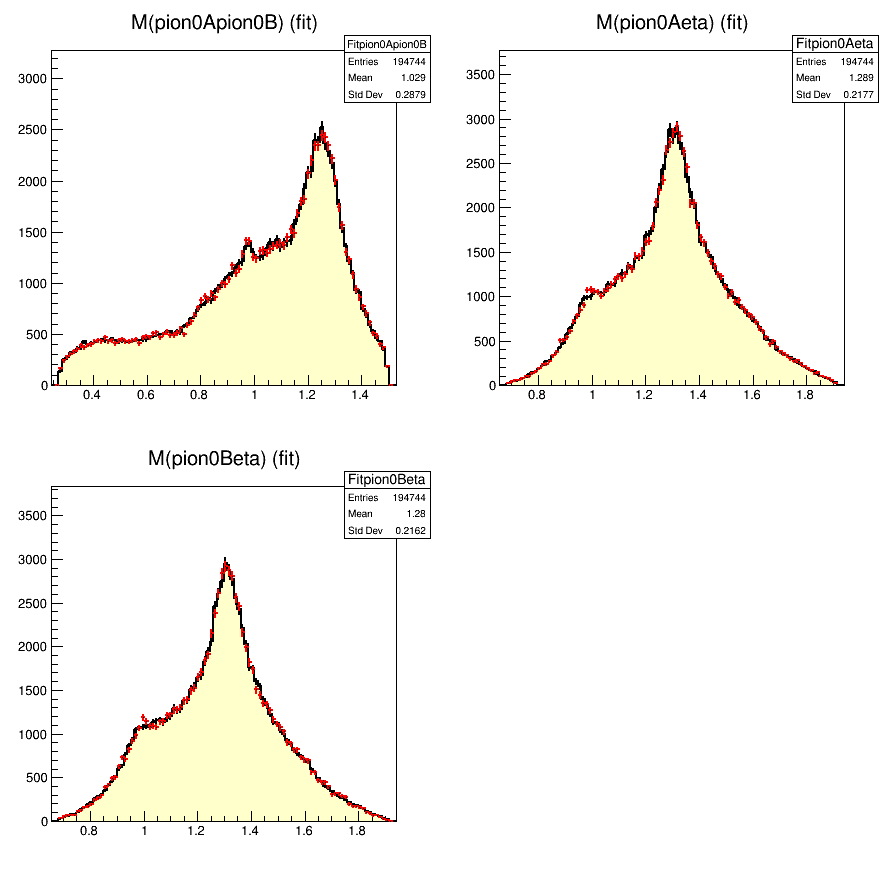

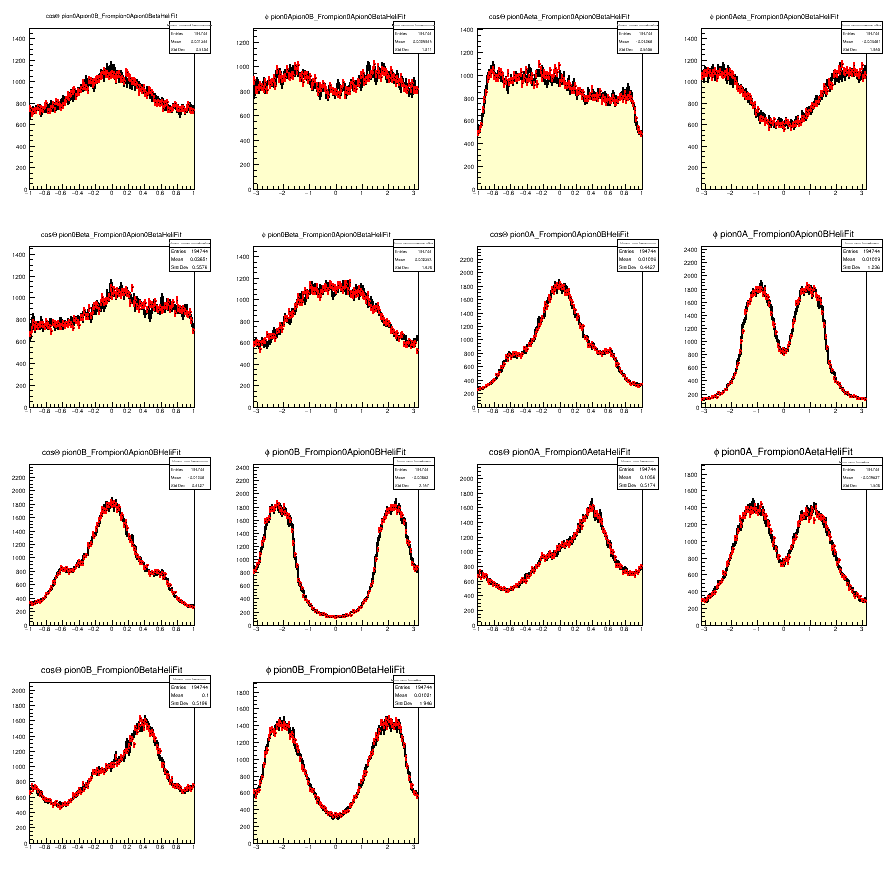

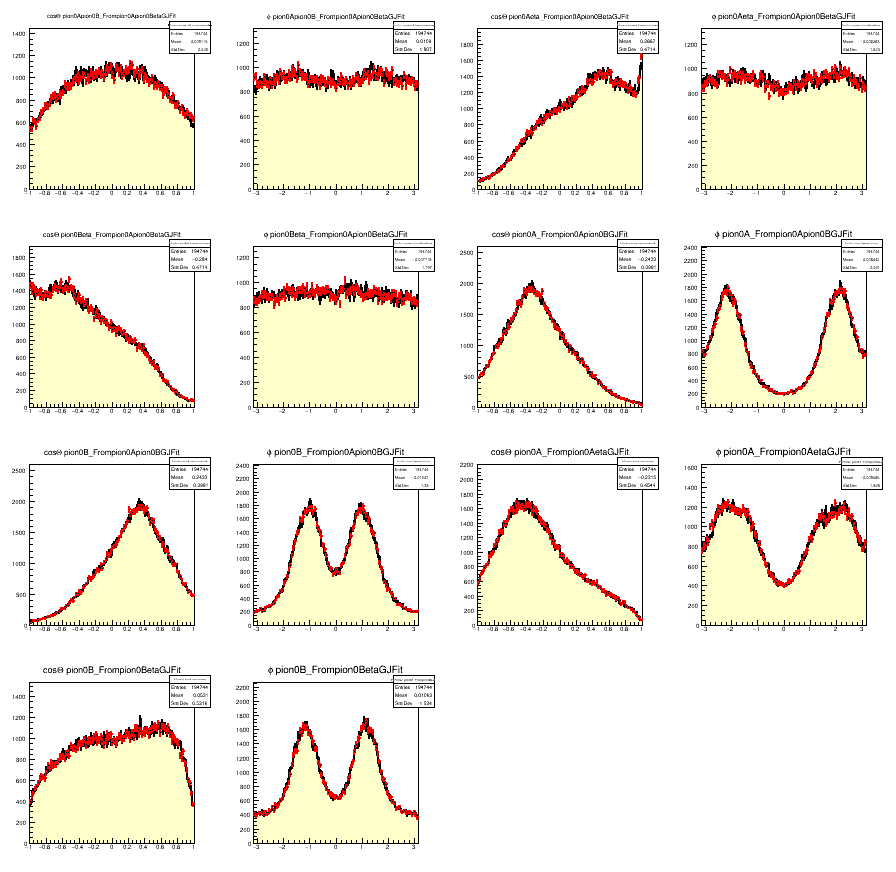

In [8]:


DataFitCompareAll("/data/jollyj/bertram/fits/pbarp/coupled_PiPiEta_PiEtaEta_KKPi/paperFinalHyper/final/Ochs2013---/4f2_0orderBgV5a/qaPiPiEta/pawianHists.root", true);

canvasMass->Draw();
canvasHeliAngles->Draw();
canvasGJAngles->Draw();
